In [113]:
from sklearn.utils.multiclass import unique_labels
from typing import Dict
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, \
    balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [114]:
wine = pd.read_csv('data/winequality-red.csv')

In [115]:
wine.shape

(1599, 12)

In [116]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [117]:
wine.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [118]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [119]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [120]:
wine.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [121]:
sns.pairplot(wine, hue = 'quality')

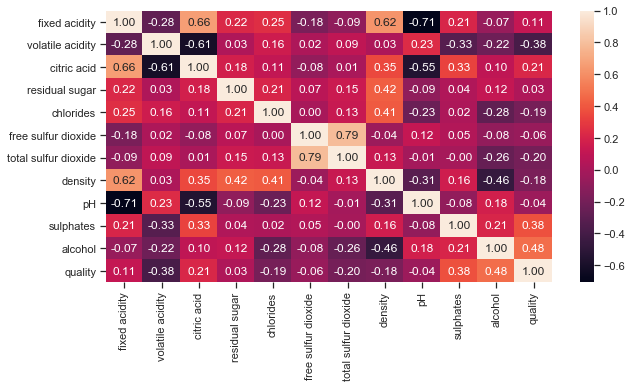

In [122]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(wine.corr(method='spearman'), annot=True, fmt='.2f')

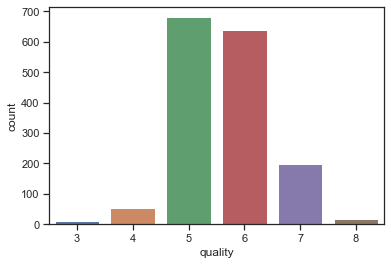

In [123]:
sns.countplot(wine['quality'])

In [124]:
#Бинарная классификация>
#Деление вина на хорошее и плохое с пределом качества
bins = (2, 5.5, 8)
group_names = ['bad', 'good']
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = group_names)
#Используем LabelEncoder для кодирования целевого признака
label_quality = LabelEncoder()
#Вино плохого качества - 0; Вино хорошего качества - 1 
wine['quality'] = label_quality.fit_transform(wine['quality'])
wine['quality'].value_counts()

1    855
0    744
Name: quality, dtype: int64

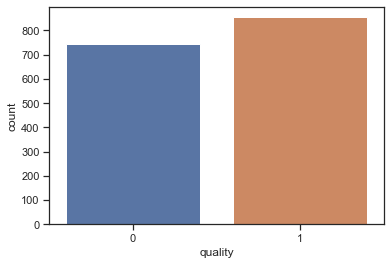

In [125]:
sns.countplot(wine['quality'])


In [126]:
#Подготовка данных
X = wine.drop('quality', axis = 1)
y = wine['quality']
#Разделение набора данных на обучающую и тестовую выборки 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
#Применение стандартного масштабирования для оптимизации результата 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [127]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [128]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data   
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [129]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [130]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

In [131]:
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

Normalized confusion matrix


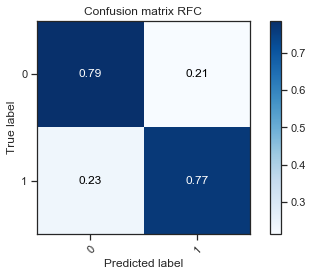

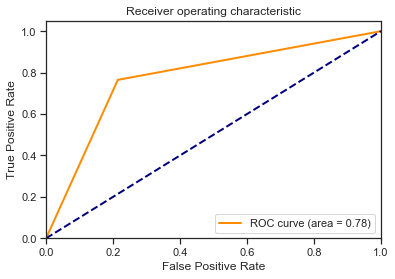

0.7753872633390706

In [132]:
#Оценим результат работы нашей модели
plot_confusion_matrix(y_test, pred_rfc, 
                      classes=np.array(['0', '1']),
                      normalize=True,
                      title='Confusion matrix RFC')
draw_roc_curve(y_test.values, pred_rfc)
balanced_accuracy_score(y_test, pred_rfc)

In [133]:
sgd = SGDClassifier(penalty=None)
sgd.fit(X_train, y_train)
pred_sgd = sgd.predict(X_test)

Normalized confusion matrix


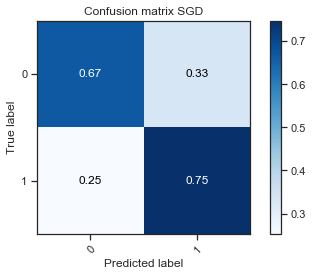

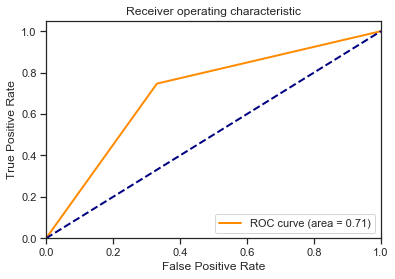

0.7079095603191988

In [134]:
#Оценим результат работы нашей модели
plot_confusion_matrix(y_test, pred_sgd, 
                      classes=np.array(['0', '1']),
                      normalize=True,
                      title='Confusion matrix SGD')
draw_roc_curve(y_test.values, pred_sgd)
balanced_accuracy_score(y_test, pred_sgd)

In [135]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)

Normalized confusion matrix


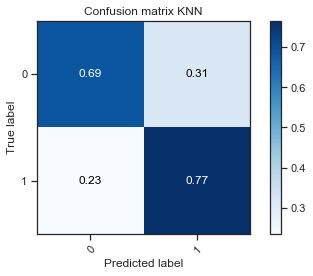

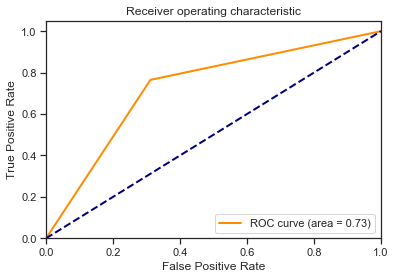

0.7266859646377719

In [136]:
#Оценим результат работы нашей модели
plot_confusion_matrix(y_test, pred_knn, 
                      classes=np.array(['0', '1']),
                      normalize=True,
                      title='Confusion matrix KNN')
draw_roc_curve(y_test.values, pred_knn)
balanced_accuracy_score(y_test, pred_knn)

In [137]:
gbs = GradientBoostingClassifier()
gbs.fit(X_train, y_train)
pred_gbs = gbs.predict(X_test)

Normalized confusion matrix


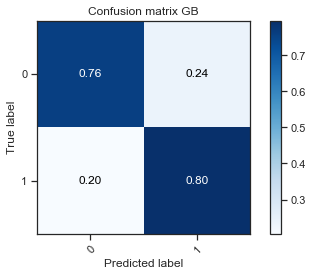

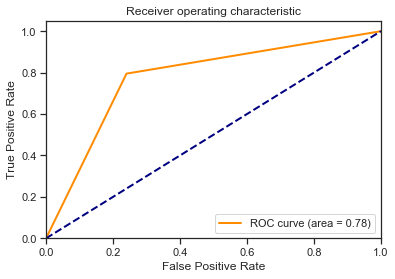

0.777460491315913

In [138]:
#Оценим результат работы нашей модели
plot_confusion_matrix(y_test, pred_gbs, 
                      classes=np.array(['0', '1']),
                      normalize=True,
                      title='Confusion matrix GB')
draw_roc_curve(y_test.values, pred_gbs)
balanced_accuracy_score(y_test, pred_gbs)

In [139]:
svc = SVC()
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)

Normalized confusion matrix


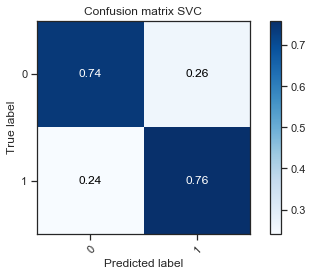

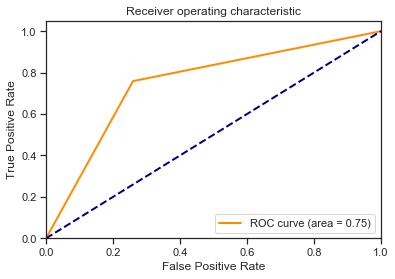

0.7496479424190268

In [140]:
#Оценим результат работы нашей модели
plot_confusion_matrix(y_test, pred_svc, 
                      classes=np.array(['0', '1']),
                      normalize=True,
                      title='Confusion matrix SVC')
draw_roc_curve(y_test.values, pred_svc)
balanced_accuracy_score(y_test, pred_svc)

In [141]:
#Поиск оптимальных параметров для модели SVC
param = {
    'C': [0.1,0.8,0.9,1,1.1,1.2,1.3,1.4],
    'kernel':['linear', 'rbf'],
    'gamma' :[0.1,0.8,0.9,1,1.1,1.2,1.3,1.4]
}
grid_svc = GridSearchCV(svc, param_grid=param, scoring='balanced_accuracy', cv=3)
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'gamma': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

In [142]:
#Лучшие параметры для модели SVC
grid_svc.best_params_

{'C': 1.2, 'gamma': 0.1, 'kernel': 'rbf'}

Normalized confusion matrix


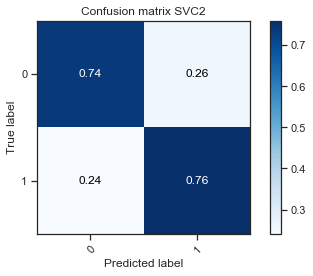

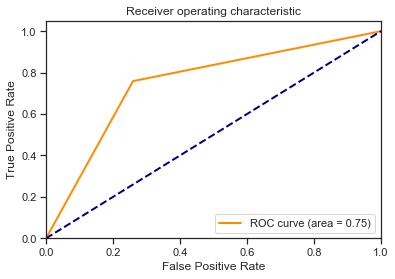

0.7496479424190268

In [143]:
# Вновь запустим наш SVC с лучшими параметрами
svc2 = SVC(C = 1.2, gamma =  0.1, kernel= 'rbf')
svc2.fit(X_train, y_train)
pred_svc2 = svc2.predict(X_test)
plot_confusion_matrix(y_test, pred_svc2, 
                      classes=np.array(['0', '1']),
                      normalize=True,
                      title='Confusion matrix SVC2')
draw_roc_curve(y_test.values, pred_svc2)
balanced_accuracy_score(y_test, pred_svc2)

In [144]:
n_range = np.array(range(1,100,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
         86, 91, 96])}]

In [145]:
grid_knn = GridSearchCV(knn, tuned_parameters, cv=3, scoring='balanced_accuracy')
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

In [146]:
#Лучшие параметры для модели KNN
grid_knn.best_params_

{'n_neighbors': 71}

Normalized confusion matrix


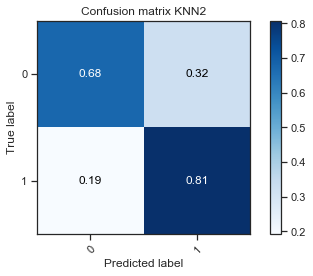

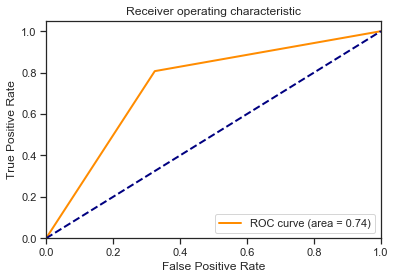

0.741276795493663

In [147]:
# Вновь запустим наш KNN с лучшими параметрами
knn2 = KNeighborsClassifier(n_neighbors=71)
knn2.fit(X_train, y_train)
pred_knn2 = knn2.predict(X_test)
plot_confusion_matrix(y_test, pred_knn2, 
                      classes=np.array(['0', '1']),
                      normalize=True,
                      title='Confusion matrix KNN2')
draw_roc_curve(y_test.values, pred_knn2)
balanced_accuracy_score(y_test, pred_knn2)

In [173]:
param_gbs = {'n_estimators':[1, 3, 5, 7, 10, 13, 16], 
                            'max_depth':[1, 3, 5, 7, 10, 13, 16],
                            'learning_rate':[0.01, 0.05, 0.1, 0.5, 2, 3, 4, 5]}
grid_gbs = GridSearchCV(gbs, param_gbs, scoring='balanced_accuracy', cv=3)
grid_gbs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [174]:
#Лучшие параметры для модели GB
grid_gbs.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 16}

Normalized confusion matrix


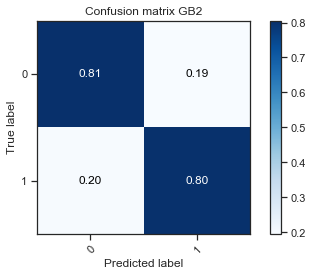

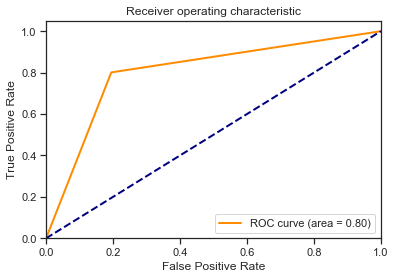

0.8031998122359568

In [179]:
# Вновь запустим наш GB с лучшими параметрами
gbs2 = GradientBoostingClassifier(n_estimators=16, max_depth=10, learning_rate=0.5)
gbs2.fit(X_train, y_train)
pred_gbs2 = gbs2.predict(X_test)
plot_confusion_matrix(y_test, pred_gbs2, 
                      classes=np.array(['0', '1']),
                      normalize=True,
                      title='Confusion matrix GB2')
draw_roc_curve(y_test.values, pred_gbs2)
balanced_accuracy_score(y_test, pred_gbs2)

In [171]:
param_sgd = {'alpha':[0.5,0.4,0.3,0.2,0.1]}
grid_sgd = GridSearchCV(sgd, param_sgd, cv=3, scoring='balanced_accuracy')
grid_sgd.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty=None, power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.5, 0.4, 0.3, 0.2, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

In [172]:
#Лучшие параметры для модели SGD
grid_sgd.best_params_

{'alpha': 0.4}

Normalized confusion matrix


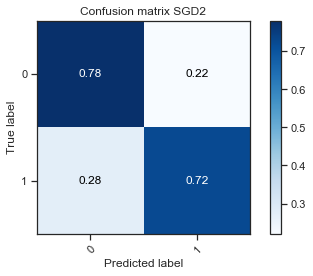

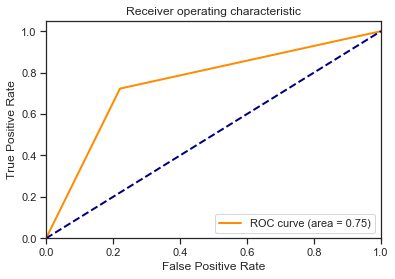

0.7510561727429197

In [153]:
# Вновь запустим наш SGD с лучшими параметрами
sgd2 = SGDClassifier(alpha=0.4)
sgd2.fit(X_train, y_train)
pred_sgd2 = sgd2.predict(X_test)
plot_confusion_matrix(y_test, pred_sgd2, 
                      classes=np.array(['0', '1']),
                      normalize=True,
                      title='Confusion matrix SGD2')
draw_roc_curve(y_test.values, pred_sgd2)
balanced_accuracy_score(y_test, pred_sgd2)

In [154]:
param_rfc = {'n_estimators':[1, 3, 5, 7, 10, 13, 16, 19],
    'max_depth':[1, 3, 5, 7, 10, 13, 16, 19],
    'random_state':[0, 2, 4, 6, 8, 10, 12, 14]} 
grid_rfc = GridSearchCV(rfc, param_rfc, cv=3, scoring='balanced_accuracy')
grid_rfc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random

In [155]:
#Лучшие параметры для модели RFC
grid_rfc.best_params_


{'max_depth': 13, 'n_estimators': 19, 'random_state': 14}

Normalized confusion matrix


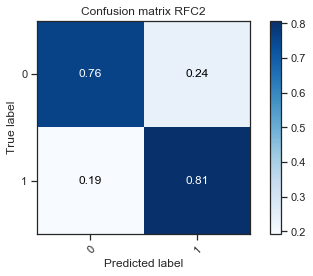

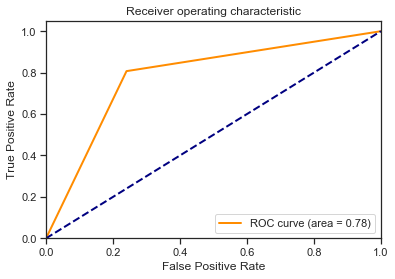

0.7834845877014551

In [156]:
# Вновь запустим наш RFC с лучшими параметрами
rfc2 = RandomForestClassifier(n_estimators=19, max_depth=13, random_state=14)
rfc2.fit(X_train, y_train)
pred_rfc2 = rfc2.predict(X_test)
plot_confusion_matrix(y_test, pred_rfc2, 
                      classes=np.array(['0', '1']),
                      normalize=True,
                      title='Confusion matrix RFC2')
draw_roc_curve(y_test.values, pred_rfc2)
balanced_accuracy_score(y_test, pred_rfc2)


<module 'matplotlib.pyplot' from 'c:\\django_projects\\untitled\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

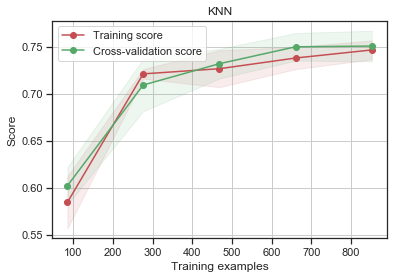

In [157]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=71), 'KNN', 
                    X_train, y_train, cv=3)

<module 'matplotlib.pyplot' from 'c:\\django_projects\\untitled\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

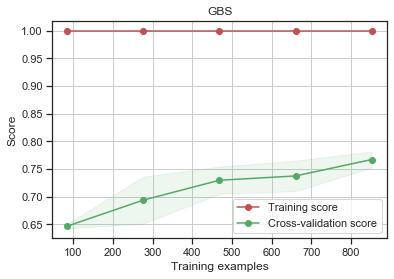

In [158]:
plot_learning_curve(GradientBoostingClassifier(n_estimators=16, max_depth=10, learning_rate=0.5), 'GBS', 
                    X_train, y_train, cv=3)

<module 'matplotlib.pyplot' from 'c:\\django_projects\\untitled\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

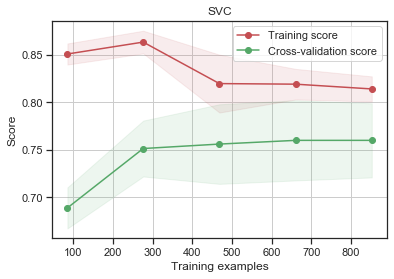

In [159]:
plot_learning_curve(SVC(C = 1.2, gamma =  0.1, kernel= 'rbf'), 'SVC', 
                    X_train, y_train, cv=3)

<module 'matplotlib.pyplot' from 'c:\\django_projects\\untitled\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

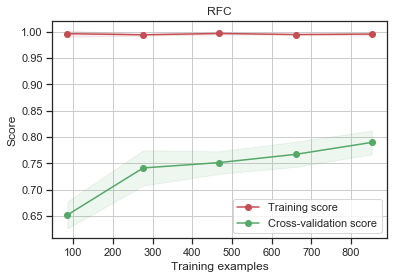

In [160]:
plot_learning_curve(RandomForestClassifier(n_estimators=19, max_depth=13, random_state=14), 'RFC', 
                    X_train, y_train, cv=3)

<module 'matplotlib.pyplot' from 'c:\\django_projects\\untitled\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

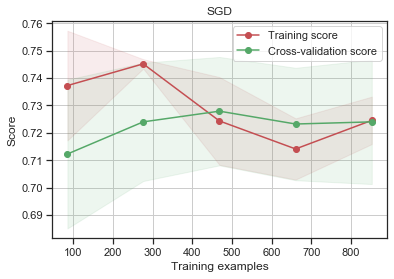

In [161]:
plot_learning_curve(SGDClassifier(alpha=0.4), 'SGD', 
                    X_train, y_train, cv=3)


<module 'matplotlib.pyplot' from 'c:\\django_projects\\untitled\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

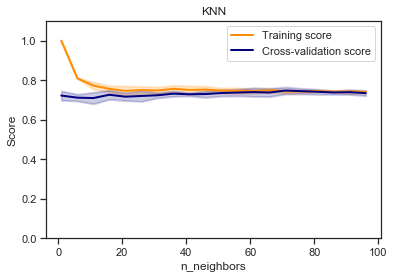

In [162]:
plot_validation_curve(KNeighborsClassifier(), 'KNN', 
                      X_train, y_train, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=3, scoring="balanced_accuracy")

<module 'matplotlib.pyplot' from 'c:\\django_projects\\untitled\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

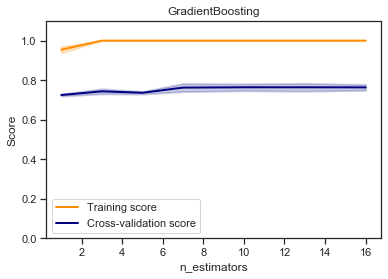

In [163]:
plot_validation_curve(GradientBoostingClassifier(n_estimators=16, max_depth=10, learning_rate=0.5), 'GradientBoosting', 
                      X_train, y_train, 
                      param_name='n_estimators', param_range=[1, 3, 5, 7, 10, 13, 16], 
                      cv=3, scoring="balanced_accuracy")

<module 'matplotlib.pyplot' from 'c:\\django_projects\\untitled\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

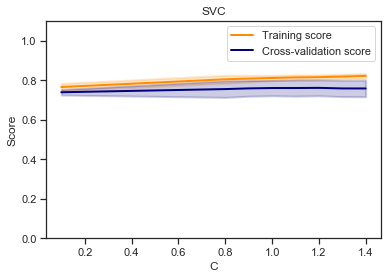

In [164]:
plot_validation_curve(SVC(C = 1.2, gamma =  0.1, kernel= 'rbf'), 'SVC', 
                    X_train, y_train, 
                    param_name='C', param_range=[0.1,0.8,0.9,1,1.1,1.2,1.3,1.4],  
                    cv=3, scoring="balanced_accuracy")

<module 'matplotlib.pyplot' from 'c:\\django_projects\\untitled\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

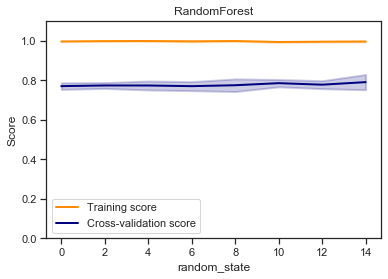

In [165]:
plot_validation_curve(RandomForestClassifier(n_estimators=19, max_depth=13, random_state=14), 'RandomForest', 
                      X_train, y_train, 
                      param_name='random_state', param_range=[0, 2, 4, 6, 8, 10, 12, 14], 
                      cv=3, scoring="balanced_accuracy")

<module 'matplotlib.pyplot' from 'c:\\django_projects\\untitled\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

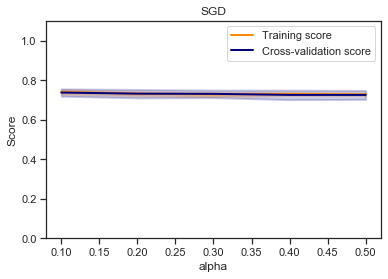

In [166]:
plot_validation_curve(SGDClassifier(alpha=0.4), 'SGD', 
                      X_train, y_train, 
                      param_name='alpha', param_range=[0.5,0.4,0.3,0.2,0.1], 
                      cv=3, scoring="balanced_accuracy")